<a href="https://colab.research.google.com/github/sid0312/OCTImageSegmentation/blob/master/unets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet-cu101

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import mxnet as mx
num_workers  = mx.context.num_gpus()
if num_workers:
  context = mx.gpu(0)
else:
  context = mx.cpu(0) 

In [0]:
import mxnet as mx
from mxnet import gluon,init,nd,autograd
mx.random.seed(1)

class network(gluon.nn.HybridBlock):
    def convoluting_part(self,input_channels,output_channels,kernel_size=3):
        shrink_net = gluon.nn.HybridSequential()
        with shrink_net.name_scope():
            shrink_net.add(gluon.nn.Conv2D(in_channels=input_channels,channels=output_channels,kernel_size=kernel_size,activation='relu'))
            shrink_net.add(gluon.nn.BatchNorm(in_channels=output_channels))
            shrink_net.add(gluon.nn.Conv2D(in_channels=output_channels,channels=output_channels,kernel_size=kernel_size,activation='relu'))
            shrink_net.add(gluon.nn.BatchNorm(in_channels=output_channels))
            shrink_net.add(gluon.nn.MaxPool2D(pool_size=(2,2)))  
        return shrink_net
    
    def deconvoluting_part(self,input_channels,hidden_channel,output_channels,kernel_size=3):
        expand_net = gluon.nn.HybridSequential()
        with expand_net.name_scope():
            expand_net.add(gluon.nn.Conv2D(channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            expand_net.add(gluon.nn.BatchNorm())
            expand_net.add(gluon.nn.Conv2D(channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            expand_net.add(gluon.nn.BatchNorm())
            expand_net.add(gluon.nn.Conv2DTranspose(channels = output_channels,kernel_size=kernel_size,strides=(2,2),padding=(1,1),output_padding=(1,1)))
        return expand_net        
      
    def plateau_block(self,input_channels,output_channels):
        plateau_net = gluon.nn.HybridSequential()
        with plateau_net.name_scope():
            plateau_net.add(gluon.nn.Conv2D(channels=512,kernel_size=3,activation='relu'))
            plateau_net.add(gluon.nn.BatchNorm())
            plateau_net.add(gluon.nn.Conv2D(channels=512,kernel_size=3,activation='relu'))
            plateau_net.add(gluon.nn.BatchNorm())
            plateau_net.add(gluon.nn.Conv2DTranspose(channels=256,kernel_size=3,strides=(2,2),padding=(1,1),output_padding=(1,1)))
        return plateau_net            
                            
    def output_block(self,input_channels,hidden_channel,output_channels,kernel_size=3):
        x = gluon.nn.HybridSequential()
        with x.name_scope():
            x.add(gluon.nn.Conv2D(in_channels=input_channels,channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=hidden_channel))
            x.add(gluon.nn.Conv2D(in_channels=hidden_channel,channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=hidden_channel))
            x.add(gluon.nn.Conv2D(in_channels=hidden_channel,channels=output_channels,kernel_size=kernel_size,padding=(1,1),activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=output_channels))
        return x
    
    def concatenate(self,upsampling_block,conv_block):
        padding = upsampling_block.shape[2]-conv_block.shape[2]
        mid_padding = padding//2
        padded_conv_block = mx.nd.pad(conv_block,mode="edge",pad_width=(0,0,0,0,mid_padding,mid_padding,mid_padding,mid_padding))
        return mx.nd.concat(upsampling_block,padded_conv_block,dim=1)

    
    def __init__(self,input_channels,output_channels,**kwargs):
        super(network,self).__init__(**kwargs)
        # convolving
        self.conv_depth0 = self.convoluting_part(input_channels,output_channels=64)
        self.conv_depth1 = self.convoluting_part(64,128)
        self.conv_depth2 = self.convoluting_part(128,256)
        
        # plateau 
        self.plateau = self.plateau_block(256,512)
        
        # deconvolving
        self.deconv_depth2 = self.deconvoluting_part(512,256,128)
        self.deconv_depth1 = self.deconvoluting_part(256,128,64)
        self.output_layer = self.output_block(128,64,output_channels)
    
    def hybrid_forward(self,F,X):
        conv_block_0 = self.conv_depth0(X)
        conv_block_1 = self.conv_depth1(conv_block_0)
        conv_block_2 = self.conv_depth2(conv_block_1)
        plateau_block_0 = self.plateau(conv_block_2)
        

        deconv_block_2 = self.concatenate(plateau_block_0,conv_block_2)
        concat_block_2 = self.deconv_depth2(deconv_block_2)
        
        deconv_block_1 = self.concatenate(concat_block_2,conv_block_1)
        concat_block_1 = self.deconv_depth1(deconv_block_1)
        
        deconv_block_0 = self.concatenate(concat_block_1,conv_block_0)
        output_layer = self.output_layer(deconv_block_0)
        return output_layer
net = network(input_channels=1,output_channels=2)

In [0]:
import numpy as np
import os
import scipy.io
from skimage.transform import resize
from tqdm import tqdm 

dataset_name = '2015_BOE_Chiu'

def atzero(x):
    a = 0 if x==0 else 1
    return a

atzero = np.vectorize(atzero,otypes=[np.float32])

def create_pipeline(paths,wi,hi,wo,ho,indexes,mat):
    x,y=[],[]
    for file_path in tqdm(paths):
        data = scipy.io.loadmat(file_path)
        images,labels = data['images'],data['manualFluid1']
        transposed_images = np.transpose(images,(2,0,1))/255.0
        resized_images = resize(transposed_images,(transposed_images.shape[0],wi,hi))
        labels = np.transpose(labels,(2,0,1))
        labels = atzero(labels)
        labels = resize(labels,(labels.shape[0],wo,ho))
        
        for index in indexes:
            x = x + [np.expand_dims(resized_images[index],0)]
            y = y + [np.expand_dims(labels[index],0)]
    return np.array(x),np.array(y)

def load_dataset(wi,hi,wo,ho):
    dir_path = '/content/drive/My Drive/2015_BOE_Chiu'
    file_path=[]
    for i in range(1,10):
        file_path.append(os.path.join(dir_path, 'Subject_0{}.mat'.format(i)))
    split = len(file_path)  
    indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
    data = scipy.io.loadmat(file_path[0])
    train_features,train_labels = create_pipeline(file_path[:split-1],wi,hi,wo,ho,indexes,data)
    val_features,val_labels = create_pipeline(file_path[split-1:],wi,hi,wo,ho,indexes,data)
    return train_features,train_labels,val_features,val_labels

In [0]:
import mxnet as mx
from mxnet import gluon,nd,autograd,init
from tqdm import trange
from mxnet import metric
def training_step(inputs,labels,optimizer,loss_fn,network,wo,ho,batch_size,flag=0):
    with autograd.record():
        outputs = network(inputs)
        outputs = outputs.transpose((0,2,3,1))
        first_dim = outputs.shape[0]
        outputs = outputs.reshape(first_dim*wo*ho,2)
        labels = labels.reshape(first_dim*wo*ho)
        loss = loss_fn(outputs,labels)
    if flag ==0:
      loss.backward()
      optimizer.step(batch_size)
      return network,loss
    elif flag==1:
      return labels,outputs

def validate(network,data,wo,ho,loss_fn,flag=0):
  _,_,val_X,val_Y = data
  val_X = mx.nd.array(val_X,ctx=context).astype('float32')
  val_Y = mx.nd.array(val_Y,ctx=context).astype('long')
  dim_1  = val_X.shape[0]
  outputs = net(val_X)
  outputs = outputs.reshape(dim_1*wo*ho,2)
  labels = val_Y.reshape(dim_1*wo*ho)
  if flag ==0:
    loss = loss_fn(outputs,labels)
    return loss.mean().asscalar()
  elif flag ==1:
    return labels,outputs

def training_full(network,batch_size,epochs,loss_fn,optimizer,data,wo,ho):
    train_features,train_labels,val_features,val_labels = data
    num_epochs = train_features.shape[0]//batch_size
    train_acc = metric.Accuracy()
    val_acc = metric.Accuracy()
    t = trange(epochs, leave=True)
    a = 0
    for e in t:
      for i in range(num_epochs):
        final_loss = 0
        batch_X = mx.nd.array(train_features[i*batch_size:(i+1)*batch_size],ctx=context).astype('float32')
        batch_Y = mx.nd.array(train_labels[i*batch_size:(i+1)*batch_size],ctx=context).astype('long')
        flag=0
        network,loss = training_step(batch_X,batch_Y,optimizer,loss_fn,network,wo,ho,batch_size,flag)
        final_loss +=loss.mean().asscalar()
        flag=1
        l,o = training_step(batch_X,batch_Y,optimizer,loss_fn,network,wo,ho,batch_size,flag)
        train_acc.update(l,o)
      validation_loss = validate(network,data,wo,ho,loss_fn)
      l1,o1 = validate(network,data,wo,ho,loss_fn,flag=1)
      val_acc.update(l1,o1)
    return network, final_loss,train_acc.get()[1],validation_loss,val_acc.get()[1]

In [7]:
(wi,hi),(wo,ho) = (284,284),(196,196)
data=()
data = load_dataset(wi, hi, wo, ho)

100%|██████████| 1/1 [00:07<00:00,  7.99s/it]


In [8]:
print(data[0].shape)

(88, 1, 284, 284)


In [9]:
print(data[1].shape)

(88, 1, 196, 196)


In [10]:
print(data[2].shape)

(11, 1, 284, 284)


In [11]:
print(data[3].shape)

(11, 1, 196, 196)


In [12]:
print(num_workers)
print(data[3][0].dtype)

1
float32


In [0]:
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
train_features = data[0]
train_labels = data[1]
val_features = data[2]
val_labels = data[3]
train_features = train_features.astype('float32')
val_features = val_features.astype('float32')
data = train_features,train_labels,val_features,val_labels

In [14]:
print(data[0].shape)

(88, 1, 284, 284)


In [15]:
net = network(input_channels=1,output_channels=2)
net.initialize()
net.summary(nd.ones((5,1,284,284)))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (5, 1, 284, 284)               0
        Activation-1                           (5, 64, 282, 282)               0
            Conv2D-2                           (5, 64, 282, 282)             640
         BatchNorm-3                           (5, 64, 282, 282)             256
        Activation-4                           (5, 64, 280, 280)               0
            Conv2D-5                           (5, 64, 280, 280)           36928
         BatchNorm-6                           (5, 64, 280, 280)             256
         MaxPool2D-7                           (5, 64, 140, 140)               0
        Activation-8                          (5, 128, 138, 138)               0
            Conv2D-9                          (5, 128, 138, 138)           73856
        BatchNorm-10        

In [16]:
print(net)

network(
  (conv_depth0): HybridSequential(
    (0): Conv2D(1 -> 64, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
    (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (conv_depth1): HybridSequential(
    (0): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
    (2): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
    (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
    (4): MaxPool2D(size=(2, 2), st

In [0]:
batch_size = 6
epochs = 100
net = network(input_channels=1,output_channels=2)
net.initialize(init=init.Xavier(),ctx=context)
optimizer =gluon.Trainer(net.collect_params(),optimizer='sgd',optimizer_params={'learning_rate':0.0004})

In [18]:
nnet, loss,acc,validation_loss,validation_accuracy = training_full(net, batch_size, epochs, loss_fn, optimizer, data, wo,ho)

100%|██████████| 100/100 [09:40<00:00,  5.80s/it]


In [24]:
print("Total loss over 100 epochs = ",loss)

Total loss over 100 epochs 3.304492235183716


In [26]:
train_loss = loss/epochs
print("Mean train loss per epoch = ",train_loss)

Mean train loss per epoch =  0.03304492235183716


In [27]:
print("Training accuracy = ", acc)

Training accuracy =  0.8822796491045398


In [29]:
print("Validation loss = ", validation_loss)

Validation loss =  0.6850178


In [30]:
print("Validation accuracy = ", validation_accuracy)

Validation accuracy =  0.8881857228048919


Accuracy is not an appropriate parameter (Sensitivity and Specificity are)  to judge the robustness of a model made for medical purposes but this notebook intends to explain the UNet Architecture using the Apache MXNet framework and not the evaluation metric as of now. Stayed tuned into the repository for further updates regarding the metrics 

In [0]:
file_name = "net.params"
nnet.save_parameters(file_name)

In [0]:
mynet = network(input_channels=1,output_channels=2)

In [0]:
mynet.load_parameters('/content/net.params', ctx=context)

In [0]:
import matplotlib.pyplot as plt
def show_results(network,features,labels,examples=4):
  figure,axis = plt.subplots(nrows=4,ncols=4,figsize=(15,4*examples))
  dim1 = features.shape[0]
  for row in range(examples):
    img_idx = np.random.randint(dim1)
    image_array = network(mx.nd.array(features[img_idx:img_idx+1],ctx=context).astype('float32')).squeeze(0).asnumpy()
    axis[row][0].imshow(np.transpose(features[img_idx], (1,2,0))[:,:,0])
    axis[row][1].imshow(np.transpose(image_array, (1,2,0))[:,:,0])
    axis[row][2].imshow(image_array.argmax(0))
    axis[row][3].imshow(np.transpose(labels[img_idx], (1,2,0))[:,:,0])
  plt.show()

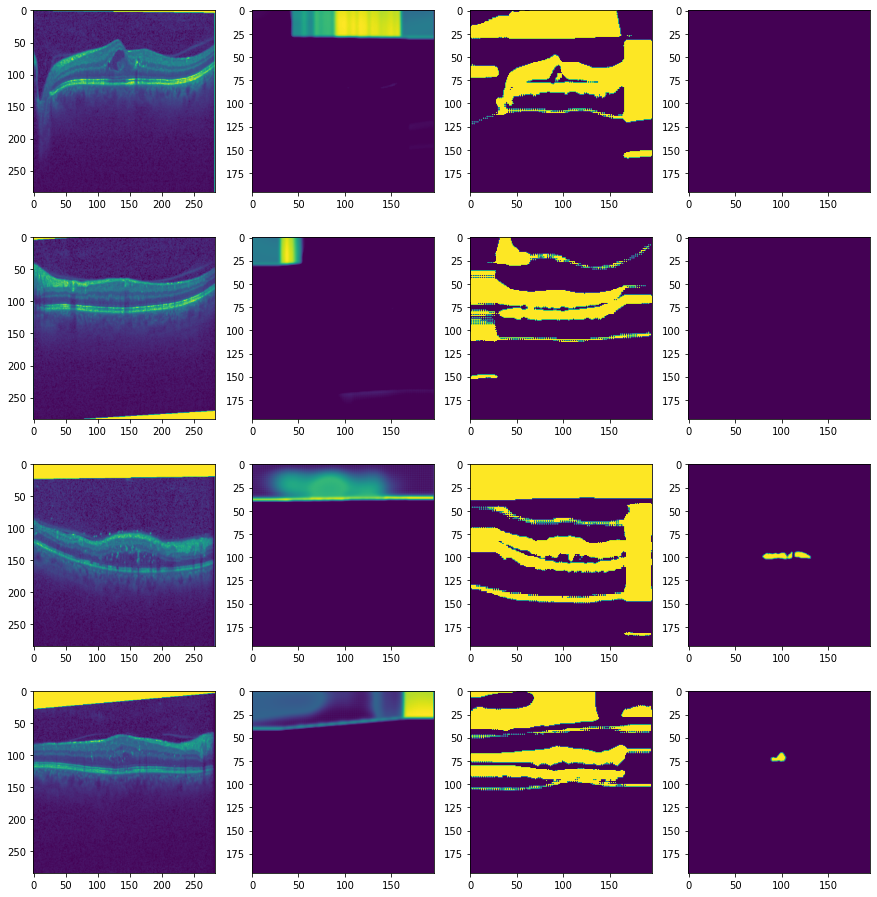

In [53]:
train_features,train_labels,val_features,val_labels = data
show_results(mynet,train_features,train_labels)

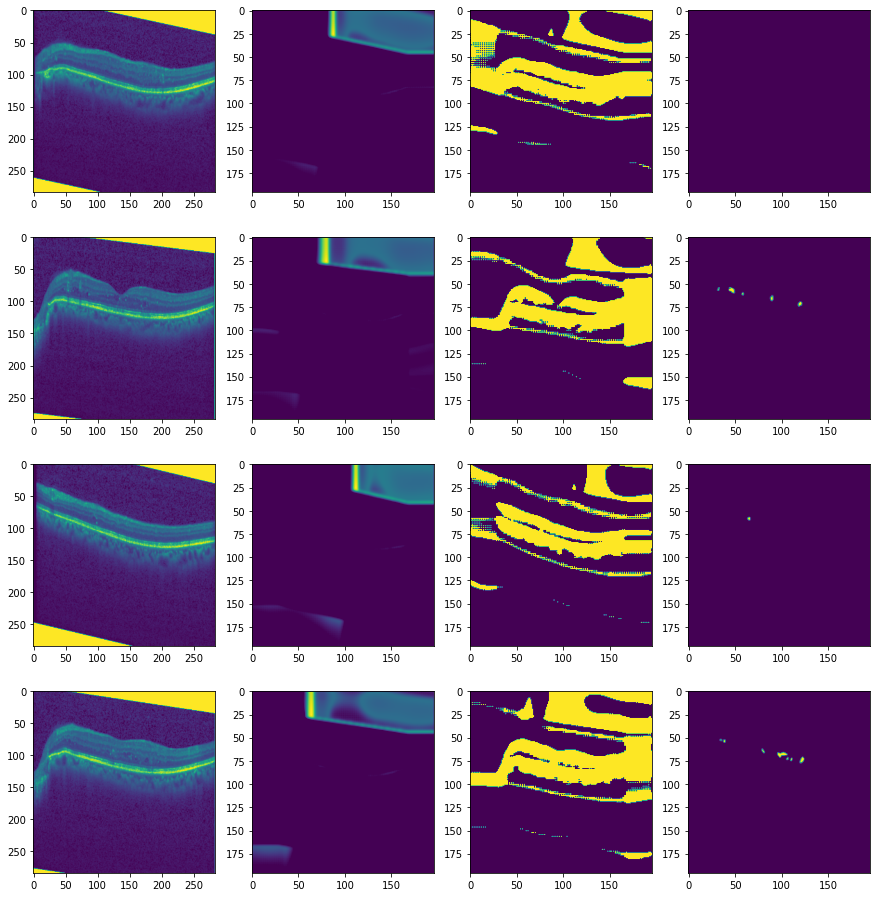

In [54]:
show_results(mynet,val_features,val_labels)